Adaptive Machine Learning for DDoS Detection


#### Data Preprocessing and Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [ ]:
# Load the dataset
df = pd.read_csv('NetBIOS.csv')

/tmp/ipykernel_489/855618205.py:2: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('NetBIOS.csv')


In [ ]:
df.shape

(3455899, 88)

In [ ]:
# columns have blank spaces, so clean by stripping the white spaces
df.columns = df.columns.str.strip()

In [ ]:
df.Label.value_counts()

Label
NetBIOS    3454578
BENIGN        1321
Name: count, dtype: int64

In [ ]:
#check for missing values
df.isnull().sum().sum()

6

In [ ]:
# Create a boolean mask to identify rows with 'NetBIOS' label
mask_netbios = (df['Label'] == 'NetBIOS') & (df.isnull().any(axis=1))

# Filter the DataFrame to keep only rows with 'NetBIOS' label and missing values
netbios_rows_with_missing = df[mask_netbios]

# Drop rows with missing values that have 'NetBIOS' label
df_cleaned = df.drop(netbios_rows_with_missing.index)

# Reset index
df_cleaned.reset_index(drop=True, inplace=True)

print('Shape of dataset after removing rows with missing values that has label NetBIOS:', df_cleaned.shape)


Shape of dataset after removing rows with missing values that has label NetBIOS: (3455894, 88)


In [ ]:
df_cleaned.shape

(3455894, 88)

In [ ]:
# Check for duplicate rows
df_cleaned.duplicated().sum()

0

In [ ]:
df_cleaned.Label.value_counts()

Label
NetBIOS    3454573
BENIGN        1321
Name: count, dtype: int64

###### Remove rows with Infinite values

In [ ]:
# Check for infinite values in each numeric column only
numeric_cols = df_cleaned.select_dtypes(include=[np.number])  # This selects only numeric columns

# Create a mask where any row contains at least one infinite value
rows_with_inf = numeric_cols.apply(lambda x: np.isinf(x) | np.isneginf(x)).any(axis=1)

# Count the number of rows with infinite values
num_rows_with_inf = rows_with_inf.sum()

# Display the number of rows with infinite values
print("Number of rows with infinite values:", num_rows_with_inf)

#rows with infinite values
rows_with_inf = df_cleaned[rows_with_inf]

# Drop rows with missing values that have 'NetBIOS' label
df_cleaned = df_cleaned.drop(rows_with_inf.index)

# Reset index if needed
df_cleaned.reset_index(drop=True, inplace=True)

print('Shape of dataset after removing rows with infinite values:', df_cleaned.shape)

Number of rows with infinite values: 130555
Shape of dataset after removing rows with infinite values: (3325339, 88)


In [ ]:
df_cleaned.columns

Index(['Unnamed: 0', 'Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Le

In [ ]:
# Check if columns 'Fwd Header Length.1' and 'Fwd Header Length' are same
col1 = 'Fwd Header Length.1'
col2 = 'Fwd Header Length'

# Check if the two columns are duplicates
are_duplicates = (df_cleaned[col1] == df_cleaned[col2]).all()

if are_duplicates:
    print(f"{col1} and {col2} are duplicates.")
    print('Data Inconsistency/ Redundant columns - We can remove one column' )
else:
    print(f"{col1} and {col2} are not duplicates.")

Fwd Header Length.1 and Fwd Header Length are duplicates.
Data Inconsistency/ Redundant columns - We can remove one column


In [ ]:
df_cleaned = df_cleaned.drop(columns =['Fwd Header Length.1'])

In [ ]:
df_cleaned.shape

(3325339, 87)

### Exploratory Data Analysis

/tmp/ipykernel_489/4209498790.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class Labels', y='Counts', data=label_counts_df, palette='viridis', width=0.4)


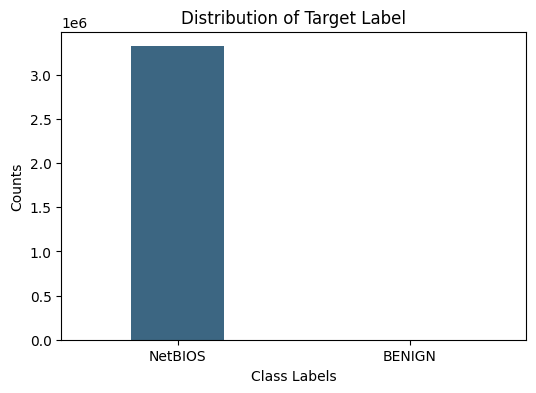

In [ ]:
# Bar plot
label_counts = df_cleaned['Label'].value_counts()

# Convert label_counts to a DataFrame for plotting
label_counts_df = label_counts.reset_index()
label_counts_df.columns = ['Class Labels', 'Counts']

# Plot the value counts
plt.figure(figsize=(6, 4))
sns.barplot(x='Class Labels', y='Counts', data=label_counts_df, palette='viridis', width=0.4)
plt.xlabel('Class Labels')
plt.ylabel('Counts')
plt.title('Distribution of Target Label')
plt.show()


In [ ]:
df_cleaned.Label.value_counts()

Label
NetBIOS    3324040
BENIGN        1299
Name: count, dtype: int64

### Data Preperation for Modeling

In [ ]:
# Feature Selection
# Drop columns that do not explain the target label
columns_to_drop = ['Unnamed: 0', 'Flow ID', 'Destination IP', 'Source IP', 'Timestamp', 'Fwd PSH Flags', 'Bwd PSH Flags',
                   'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
                   'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate','SimillarHTTP']

df_model = df_cleaned.drop(columns=columns_to_drop)


In [ ]:
df_model.shape

(3325339, 71)

#### Outliers

In [ ]:
import pandas as pd

numeric_cols = df_model.select_dtypes(include='number').columns

# Create an initial mask with no outliers
outliers_mask = pd.Series(False, index=df_model.index)

# Loop through each numeric column to update the mask
for col in numeric_cols:
    Q1 = df_model[col].quantile(0.25)
    Q3 = df_model[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Update the mask to include outliers in the current column but only for 'NetBIOS' rows
    outliers_mask |= ((df_model[col] < lower_bound) | (df_model[col] > upper_bound)) & (df_model['Label'] == 'NetBIOS')


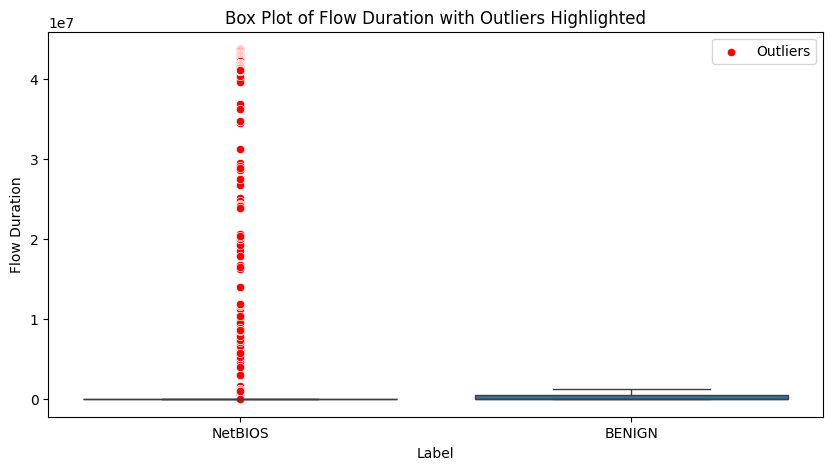

In [ ]:
plt.figure(figsize=(10, 5))

# Box plot without outliers for 'Flow Duration'
sns.boxplot(x=df_model['Label'], y=df_model['Flow Duration'], showfliers=False)

# Highlight outliers for 'Flow Duration'
sns.scatterplot(x=df_model['Label'][outliers_mask], y=df_model['Flow Duration'][outliers_mask], color='red', label='Outliers')

plt.title('Box Plot of Flow Duration with Outliers Highlighted')
plt.xlabel('Label')
plt.ylabel('Flow Duration')
plt.legend()
plt.show()

In [ ]:
# Filter out the rows with outliers in 'NetBIOS' label
df_model_clean = df_model[~outliers_mask]

# Print the shape of the original and the clean DataFrame
print("Original DataFrame shape:", df_model.shape)
print("Clean DataFrame shape:", df_model_clean.shape)


Original DataFrame shape: (3325339, 71)
Clean DataFrame shape: (2054816, 71)


In [ ]:
df_model_clean.Label.value_counts()

Label
NetBIOS    2053517
BENIGN        1299
Name: count, dtype: int64

In [ ]:
# Label encoding for Target label
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform the 'Label' column
df_model_clean['Label'] = label_encoder.fit_transform(df_model_clean['Label'])

/tmp/ipykernel_489/1087481462.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_clean['Label'] = label_encoder.fit_transform(df_model_clean['Label'])


In [ ]:
X = df_model_clean.drop(columns=['Label'])
y = df_model_clean['Label']


#### Sampling Method

In [ ]:
#  Undersample the majority class
# Adjust the strategy as needed

rus = RandomUnderSampler(sampling_strategy=0.2)
X, y = rus.fit_resample(X, y)


In [ ]:
print("After Under sampling:")

counts = pd.Series(y).value_counts()

# Print the counts
print("Counts of each class:")
print(counts)


After Under sampling:
Counts of each class:
Label
1    6495
0    1299
Name: count, dtype: int64


In [ ]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(6235, 70)

After Under sampling:
Counts of each class:
Label
1    5208
0    1027
Name: count, dtype: int64


/tmp/ipykernel_489/3199561635.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis", width =0.4)


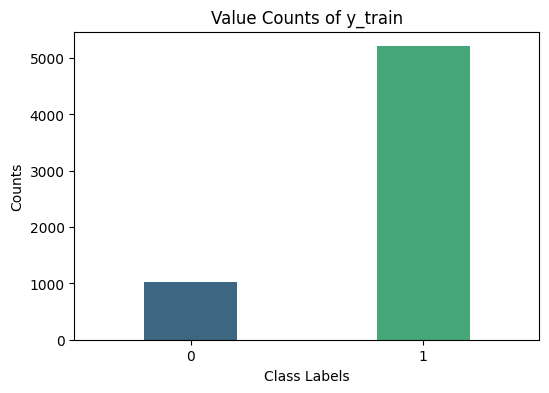

In [ ]:
print("After Under sampling:")

counts = pd.Series(y_train).value_counts()

# Print the counts
print("Counts of each class:")
print(counts)
# Plot the value counts
plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values, palette="viridis", width =0.4)
plt.xlabel('Class Labels')
plt.ylabel('Counts')
plt.title('Value Counts of y_train')
plt.show()

#### Train Test split && SMOTE

In [ ]:
# Apply SMOTE
smote = SMOTE(sampling_strategy=0.5)  # This will balance the classes
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


After Under sampling:
Counts of each class:
Label
1    5208
0    2604
Name: count, dtype: int64


/tmp/ipykernel_489/953710735.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis", width =0.4)


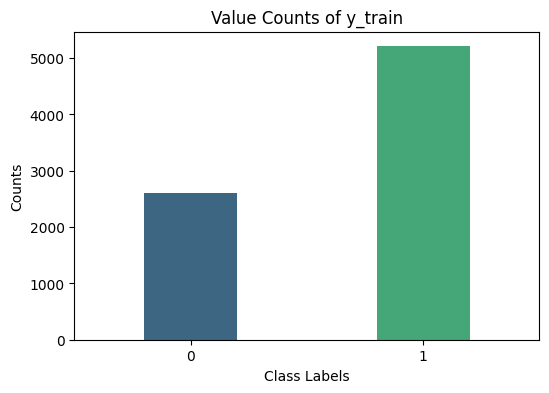

In [ ]:
print("After Under sampling:")

counts = pd.Series(y_train_balanced).value_counts()

# Print the counts
print("Counts of each class:")
print(counts)
# Plot the value counts
plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values, palette="viridis", width =0.4)
plt.xlabel('Class Labels')
plt.ylabel('Counts')
plt.title('Value Counts of y_train')
plt.show()

#### Dimensionality Reduction

In [ ]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Instantiate PCA
pca = PCA(n_components=0.95)  # Adjust the number of components as needed

# Pipeline that first scales the data then reduces dimension with PCA
pipeline = make_pipeline(scaler, pca)

# Fit and transform the data
X_train_pca = pipeline.fit_transform(X_train_balanced)

In [ ]:
print(X_train_pca.shape, y_train.shape)


(7812, 19) (6235,)


### Evaluation function

In [ ]:
def evaluate_predictions(predictions, model):

    # Calculate and print metrics
    accuracy = accuracy_score(y_test, predictions)
    weighted_precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
    weighted_recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_test, predictions, average='weighted', zero_division=0)
    class_report = classification_report(y_test, predictions, zero_division=0)

    print(f'Evaluation Metrics for {model}:')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {weighted_precision:.4f}")
    print(f"Weighted Recall: {weighted_recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n")
    print(class_report)



#### LogisticRegression

##### Before Regularization

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize the Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)  # Increase max_iter if convergence issues arise

# Fit the model on the training data
log_reg.fit(X_train_pca, y_train_balanced)

# Predicting the test set results
y_pred_log_reg = log_reg.predict(pipeline.transform(X_test))

# Evaluating the model
evaluate_predictions(y_pred_log_reg, model = 'Logistic Regresion before Regularization')

Evaluation Metrics for Logistic Regresion before Regularization:
Accuracy: 1.0000
Weighted Precision: 1.0000
Weighted Recall: 1.0000
F1 Score: 1.0000

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       272
           1       1.00      1.00      1.00      1287

    accuracy                           1.00      1559
   macro avg       1.00      1.00      1.00      1559
weighted avg       1.00      1.00      1.00      1559



##### After Regularization

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Fit models
log_reg_regularization.fit(X_train_pca, y_train_balanced)

# Evaluate models
y_pred_log_reg_regularization = log_reg_regularization.predict(pipeline.transform(X_test))

# Evaluating the model
evaluate_predictions(y_pred_log_reg_regularization, model = 'Logistic Regresion after Regularization')



Evaluation Metrics for Logistic Regresion after Regularization:
Accuracy: 0.8281
Weighted Precision: 0.8577
Weighted Recall: 0.8281
F1 Score: 0.7527

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.01      0.03       272
           1       0.83      1.00      0.91      1287

    accuracy                           0.83      1559
   macro avg       0.91      0.51      0.47      1559
weighted avg       0.86      0.83      0.75      1559



#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

rf = RandomForestClassifier(n_estimators=5, max_depth=10, random_state=42)

rf.fit(X_train_pca, y_train_balanced)

# Evaluate models
y_pred_rf = rf.predict(pipeline.transform(X_test))

# Evaluate the Random Forest model
# Evaluating the model
evaluate_predictions(y_pred_rf, model = 'Random forest')


Evaluation Metrics for Random forest:
Accuracy: 1.0000
Weighted Precision: 1.0000
Weighted Recall: 1.0000
F1 Score: 1.0000

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       272
           1       1.00      1.00      1.00      1287

    accuracy                           1.00      1559
   macro avg       1.00      1.00      1.00      1559
weighted avg       1.00      1.00      1.00      1559



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Parameters distributions
param_dist = {
    'n_estimators': randint(100, 200),  # Number of trees in the forest
    'max_depth': randint(3, 20),       # Maximum depth of each tree
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20)    # Minimum number of samples required to be at a leaf node
}

# Initialize RandomizedSearchCV with Random Forest classifier
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100,
                                   scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV on the training data
random_search.fit(X_train_pca, y_train_balanced)

# Predict the test set results using the best model found
y_pred_best_rf_hp = random_search.predict(pipeline.transform(X_test))

evaluate_predictions(y_pred_best_rf_hp, model = 'Random forest')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Evaluation Metrics for Random forest:
Accuracy: 1.0000
Weighted Precision: 1.0000
Weighted Recall: 1.0000
F1 Score: 1.0000

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       272
           1       1.00      1.00      1.00      1287

    accuracy                           1.00      1559
   macro avg       1.00      1.00      1.00      1559
weighted avg       1.00      1.00      1.00      1559



### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan', p=2)

# Fit the model on the training data
knn.fit(X_train_pca, y_train_balanced)

# Predicting the test set results
y_pred_knn = knn.predict(pipeline.transform(X_test))

evaluate_predictions(y_pred_knn, model = 'KNN')

Evaluation Metrics for KNN:
Accuracy: 1.0000
Weighted Precision: 1.0000
Weighted Recall: 1.0000
F1 Score: 1.0000

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       272
           1       1.00      1.00      1.00      1287

    accuracy                           1.00      1559
   macro avg       1.00      1.00      1.00      1559
weighted avg       1.00      1.00      1.00      1559



### XG Boost

In [ ]:
import xgboost as xgb


# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, learning_rate=0.01,
                              max_depth=3, subsample=0.8, colsample_bytree=0.8, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train_pca, y_train_balanced)

# Predicting the test set results
y_pred_xgb = xgb_model.predict(pipeline.transform(X_test))

evaluate_predictions(y_pred_xgb, model = 'XG Boost')


Evaluation Metrics for XG Boost:
Accuracy: 0.8255
Weighted Precision: 0.6815
Weighted Recall: 0.8255
F1 Score: 0.7466

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       272
           1       0.83      1.00      0.90      1287

    accuracy                           0.83      1559
   macro avg       0.41      0.50      0.45      1559
weighted avg       0.68      0.83      0.75      1559



### SVM

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=0.1, random_state=42)

# Fit the SVM model on the training data
svm.fit(X_train_pca, y_train_balanced)

# Predicting the test set results
y_pred_svm = svm.predict(pipeline.transform(X_test))

# Evaluating the model
evaluate_predictions(y_pred_svm, model = 'SVM')

Evaluation Metrics for SVM:
Accuracy: 0.9994
Weighted Precision: 0.9994
Weighted Recall: 0.9994
F1 Score: 0.9994

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       272
           1       1.00      1.00      1.00      1287

    accuracy                           1.00      1559
   macro avg       1.00      1.00      1.00      1559
weighted avg       1.00      1.00      1.00      1559



In [ ]:
#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(max_depth=1, random_state=42)

# Fit the model on the training data
dt_classifier.fit(X_train_pca, y_train_balanced)

# Predicting the test set results
y_pred_dt = dt_classifier.predict(pipeline.transform(X_test))

# Evaluating the model
evaluate_predictions(y_pred_dt, model = 'Decision Tree')


Evaluation Metrics for Decision Tree:
Accuracy: 1.0000
Weighted Precision: 1.0000
Weighted Recall: 1.0000
F1 Score: 1.0000

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       272
           1       1.00      1.00      1.00      1287

    accuracy                           1.00      1559
   macro avg       1.00      1.00      1.00      1559
weighted avg       1.00      1.00      1.00      1559



In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize Decision Tree with increased regularization-like parameters
dt_classifier = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    max_leaf_nodes=30,
    random_state=42
)

# Fit the model on the training data
dt_classifier.fit(X_train_pca, y_train_balanced)

# Predicting the test set results
y_pred_dt_hp = dt_classifier.predict(pipeline.transform(X_test))

# Evaluating the model
evaluate_predictions(y_pred_dt_hp, model = 'Decision Tree with hyperparameter tuning')


Evaluation Metrics for Decision Tree with hyperparameter tuning:
Accuracy: 1.0000
Weighted Precision: 1.0000
Weighted Recall: 1.0000
F1 Score: 1.0000

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       272
           1       1.00      1.00      1.00      1287

    accuracy                           1.00      1559
   macro avg       1.00      1.00      1.00      1559
weighted avg       1.00      1.00      1.00      1559



### plot accuracies

In [ ]:
# Example dictionary of model accuracies
model_accuracies = {
    'LR': 0.8287,
    'RF': 1,
    'XGB': 0.8255,
    'SVM': 0.9994,
    'KNN': 1,
    'DT' : 0.994
}


/tmp/ipykernel_489/2321366263.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='viridis', width=0.4)


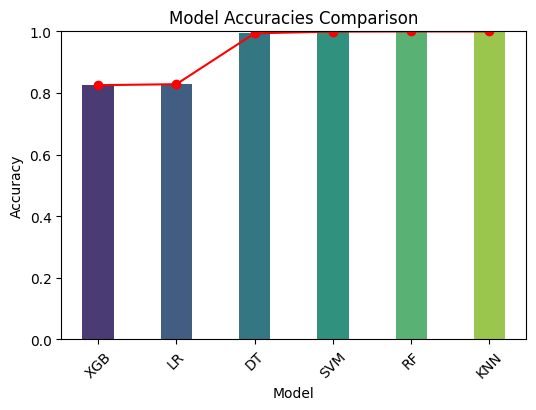

In [ ]:

accuracy_df = pd.DataFrame(list(model_accuracies.items()), columns=['Model', 'Accuracy'])
accuracy_df = accuracy_df.sort_values(by='Accuracy')
# Plot the accuracies
# Plot the accuracies
plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='viridis', width=0.4)
plt.plot(accuracy_df['Model'], accuracy_df['Accuracy'], color='red', marker='o')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies Comparison')
plt.ylim(0, 1)  # Set y-axis range from 0 to 1 for better comparison
plt.xticks(rotation=45)  # Rotate model names for better readability
plt.show()


### Saving balanced datasets for further future usage

In [ ]:

X_train_balanced_df = pd.DataFrame(X_train_balanced)
y_train_balanced_df = pd.DataFrame(y_train_balanced, columns=['Label'])

# Combine X and y into a single DataFrame
balanced_df = pd.concat([X_train_balanced_df, y_train_balanced_df], axis=1)

# Save the DataFrame to a CSV file
balanced_df.to_csv('balanced_train_data.csv', index=False)


In [ ]:
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test, columns=['Label'])

# Combine X and y into a single DataFrame
balanced_df = pd.concat([X_test_df, y_test_df], axis=1)

# Save the DataFrame to a CSV file
balanced_df.to_csv('balanced_test_data.csv', index=False)